### DATA BAYES OP

Bayesian optimization for pool based data.

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import sklearn.gaussian_process as gp
from sklearn.gaussian_process.kernels import Sum as kSum
from sklearn import preprocessing

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

# from scipy.stats import norm
from scipy.optimize import minimize

from utils import *

from tqdm import trange

In [2]:
def set_seeds(seed=42):
    """set all library random seeds"""
    random.seed(seed)
    np.random.seed(seed)

def UCB(pred, epsilon=2):
    """Function for computing the lower confidence bound of a feature set. Exploration 
    and Exploitation can be tuned using the epislon param. A high epsilon value means 
    more exploration."""
    
    return pred[0] + epsilon * pred[1]

In [36]:
dataset = 'P3HT'
df = pd.read_csv(f"datasets/{dataset}_dataset.csv")

# take the average of duplicate entries, not always a good idea
df = df.groupby(list(df.columns[:-1])).mean()
df = pd.DataFrame(df.reset_index())

# convert to torch tensors
N = len(df)
X_ = df.iloc[:, :-1].values
y_ = df.iloc[:, -1].values

# We are using predefined candidates, so we can scale at the start
Scaler = preprocessing.StandardScaler()
Scaler.fit(X_)

StandardScaler()

In [37]:
ARD = False

if ARD:
    l = np.ones(X_.shape[1])
else:
    l = 1

bias = gp.kernels.ConstantKernel(constant_value=l)
Matern52 = gp.kernels.Matern(length_scale=l, nu=2.5) + bias

seed_list = [4295, 8508, 326, 3135, 1549, 2528, 1274, 6545, 5971, 6269, 2422, 4287, 9320, 4932, 951, 4304, 1745, 5956, 7620, 4545, 6003, 9885, 5548, 9477, 30, 8992, 7559, 5034, 9071, 6437, 3389, 9816, 8617, 3712, 3626, 1660, 3309, 2427, 9872, 938, 5156, 7409, 7672, 3411, 3559, 9966, 7331, 8273, 8484, 5127, 2260, 6054, 5205, 311, 6056, 9456, 928, 6424, 7438, 8701, 8634, 4002, 6634, 8102, 8503, 1540, 9254, 7972, 7737, 3410, 4052, 8640, 9659, 8093, 7076, 7268, 2046, 7492, 3103, 3034, 7874, 5438, 4297, 291, 5436, 9021, 3711, 7837, 9188, 2036, 8013, 6188, 3734, 187, 1438, 1061, 674, 777, 7231, 7096, 3360, 4278, 5817, 5514, 3442, 6805, 6750, 8548, 9751, 3526, 9969, 8979, 1526, 1551, 2058, 6325, 1237, 5917, 5821, 9946, 5049, 654, 7750, 5149, 3545, 9165, 2837, 5621, 6501, 595, 3181, 1747, 4405, 4480, 4282, 9262, 6219, 3960, 4999, 1495, 6007, 9642, 3902, 3133, 1085, 3278, 1104, 5939, 7153, 971, 8733, 3785, 9056, 2020, 7249, 5021, 3384, 8740, 4593, 7869, 9941, 8813, 3688, 8139, 6436, 3742, 5503, 1587, 4766, 9846, 9117, 7001, 4853, 9346, 4927, 8480, 5298, 4753, 1151, 9768, 5405, 6196, 5721, 3419, 8090, 8166, 7834, 1480, 1150, 9002, 1134, 2237, 3995, 2029, 5336, 7050, 6857, 8794, 1754, 1184, 3558, 658, 6804, 8750, 5088, 1136, 626, 8462, 5203, 3196, 979, 7419, 1162, 5451, 6492, 1562, 8145, 8937, 8764, 4174, 7639, 8902, 7003, 765, 1554, 6135, 1689, 9530, 1398, 2273, 7925, 5948, 1036, 868, 4617, 1203, 7680, 7, 93, 3128, 5694, 6979, 7136, 8084, 5770, 9301, 1599, 737, 7018, 3774, 9843, 2296, 2287, 9875, 2349, 2469, 8941, 4973, 3798, 54, 2938, 4665, 3942, 3951, 9400, 3094, 2248, 3376, 1926, 5180, 1773, 3681, 1808, 350, 6669, 826, 539, 5313, 6193, 5752, 9370, 2782, 8399, 4881, 3166, 4906, 5829, 4827, 29, 6899, 9012, 6986, 4175, 1035, 8320, 7802, 3777, 6340, 7798, 7705]

In [38]:
op_budget = 100 # number of optimization cycles to perform
n_initial = 10 # number of initial experiments to perform

set_seeds(seed_list[0])

idx = np.random.choice(N, size=n_initial, replace=False)
X = X_.copy()[idx]
y = y_.copy()[idx]

for trial in trange(op_budget):
    X = Scaler.transform(X)

    gp_model = gp.GaussianProcessRegressor(kernel=Matern52,
                                    alpha=0.01, # set the noise level for the data
                                    n_restarts_optimizer=25,
                                    normalize_y=True,
                                    random_state=seed_list[0])
    
    gp_model.fit(X, y)

    pred = gp_model.predict(Scaler.transform(X_), return_std=True)
    acqf_vals = UCB(pred, epsilon=2)
    acqf_vals[idx] = -100
    idx = np.concatenate([idx, [np.argmax(acqf_vals)]])

    X = X_.copy()[idx]
    y = y_.copy()[idx]

100%|██████████| 100/100 [00:15<00:00,  6.43it/s]


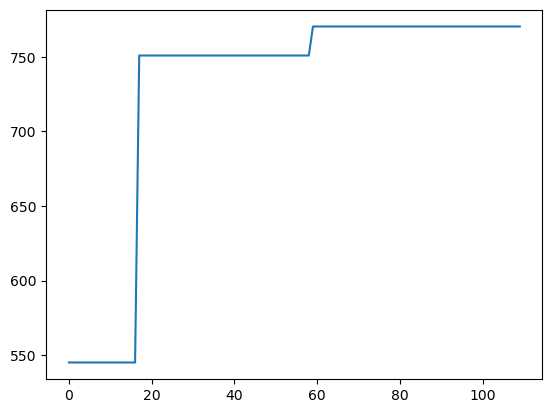

In [34]:
plt.plot(np.maximum.accumulate(y), label='True')

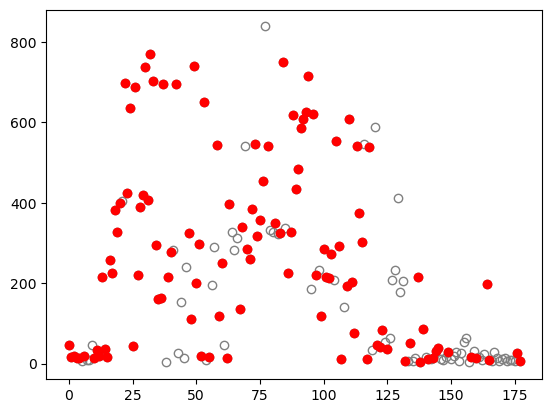

In [40]:
plt.plot(y_, ls='none', marker='o', mfc='None', color='grey')
plt.scatter(idx, y, color='red', label='Acquired', zorder=100)